In [20]:
# %%
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
#For interactive plots 

import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate, get_movie, get_genre_counts,get_1_2_movies


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and processing 


In [21]:
#loading the inflation rate data set from the columbia bank 
inflation_rate_df=get_inflation_rate()

#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')

#Data frame with all the movies with processing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

5163 when we drop collections where 1 movie doesn't have release date => confuses the order
5169 when we just drop the movies with missing date and not other movies in the same collection
should we add this in utils before adding order of movies ?

## Data presentation 

### General numerical analysis 


In [65]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise_df)}")


count    1592.00000
mean        3.24309
std         3.75448
min         2.00000
25%         2.00000
50%         2.00000
75%         3.00000
max        66.00000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5163
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


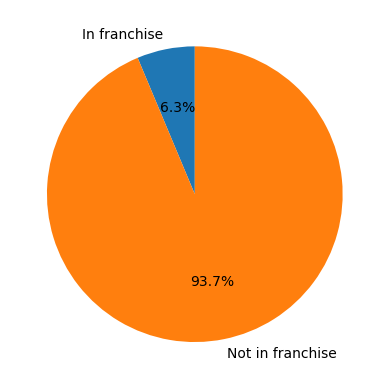

In [66]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

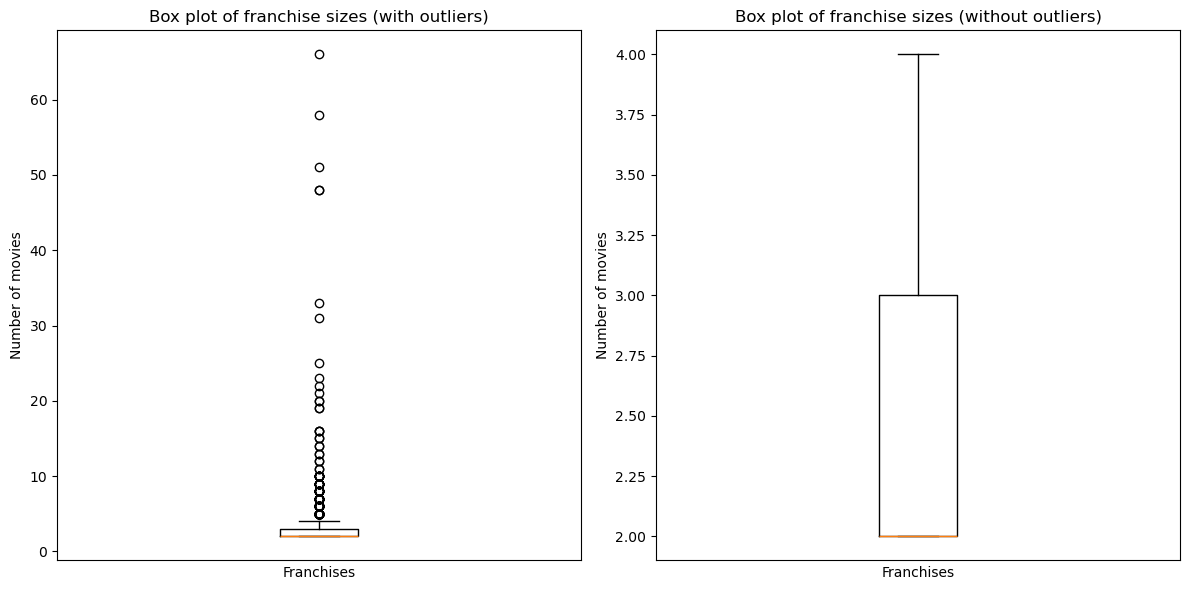

In [67]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

# Univariate Analysis 

In this part we've investigated each column of the dataset and visualized what we are working with and compared movie in franchise and movie that aren't.

## Genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

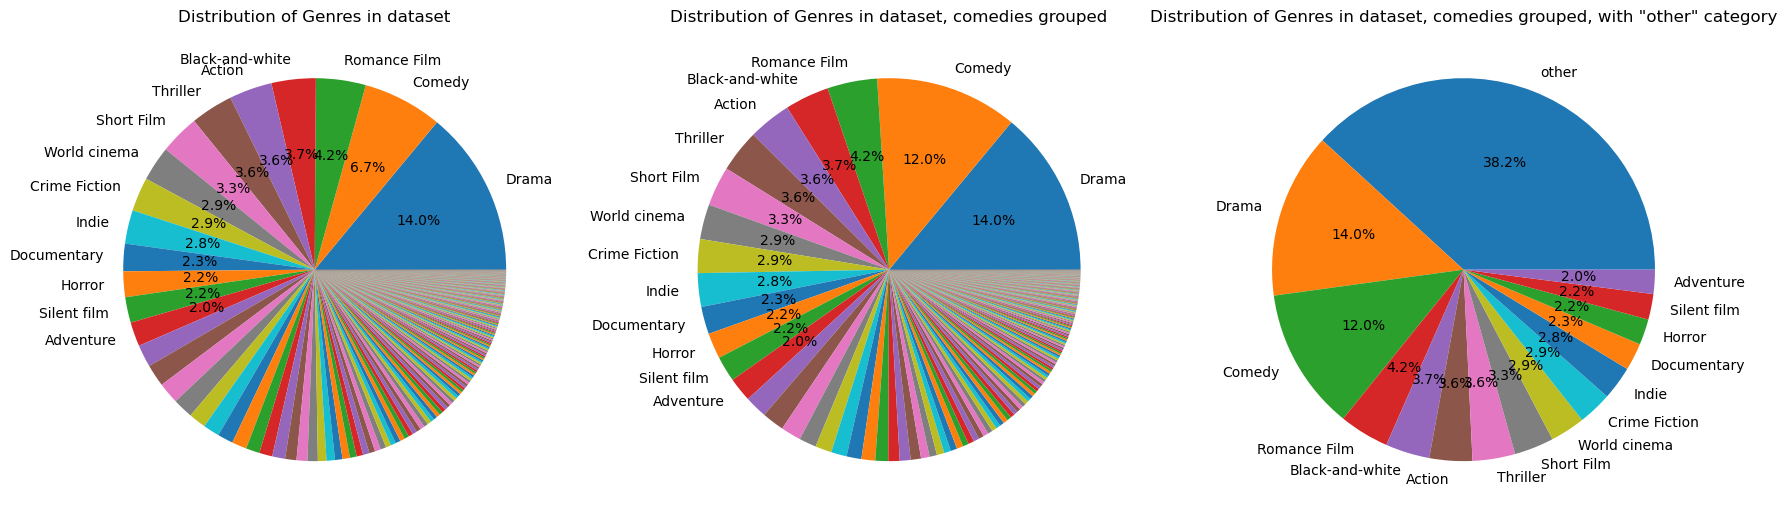

In [68]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(movies_df_raw)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

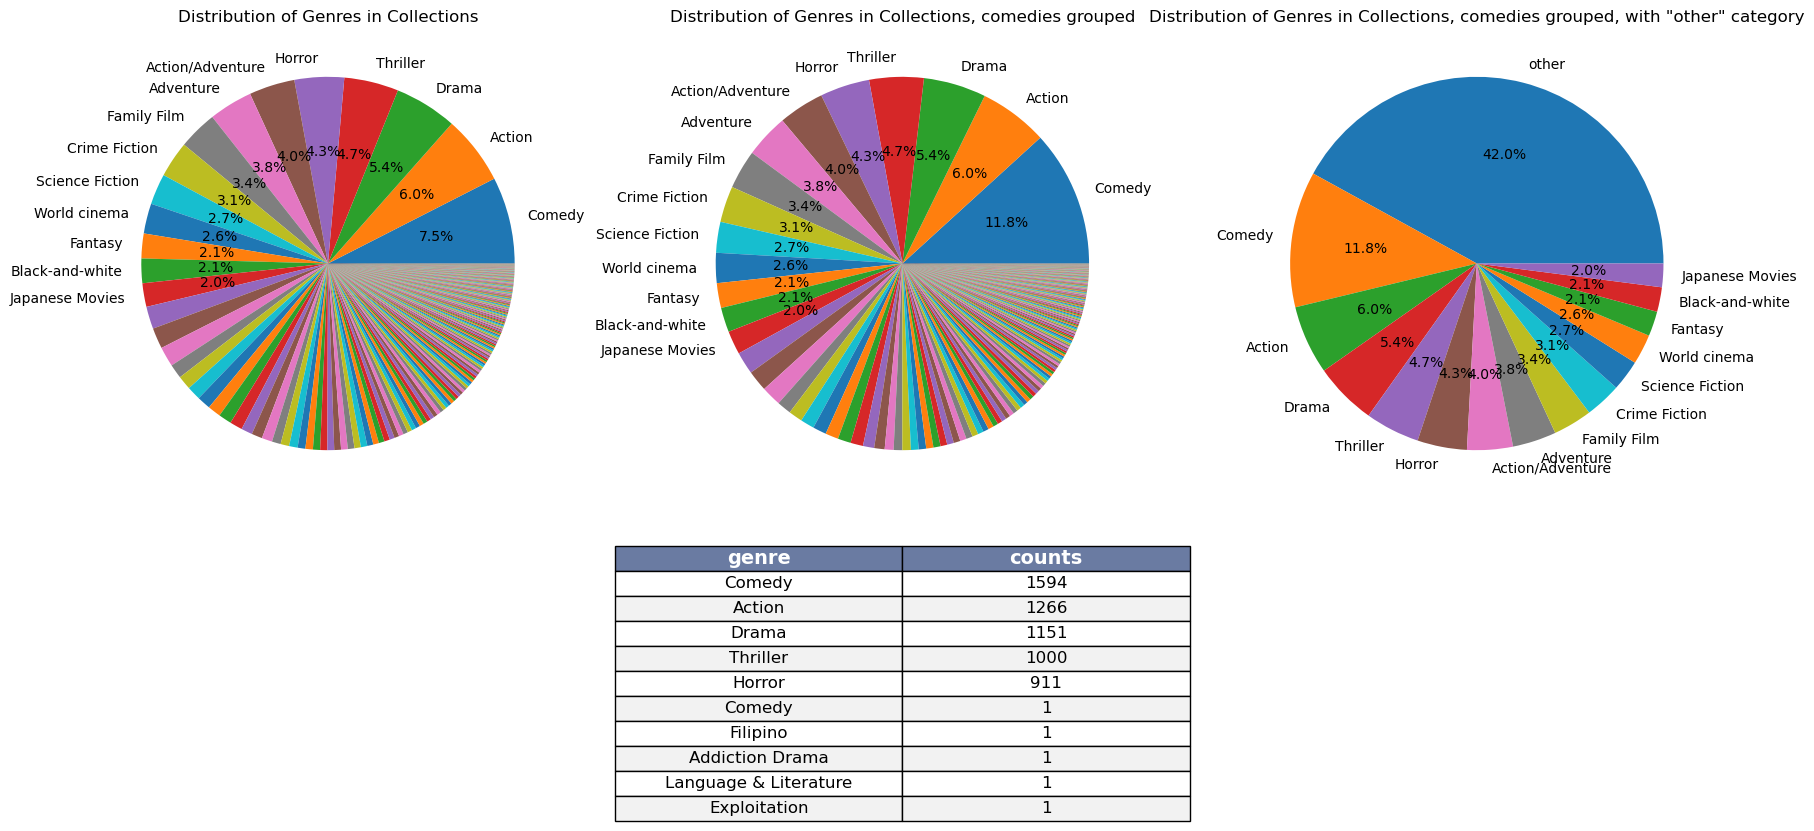

In [69]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(franchise_df)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

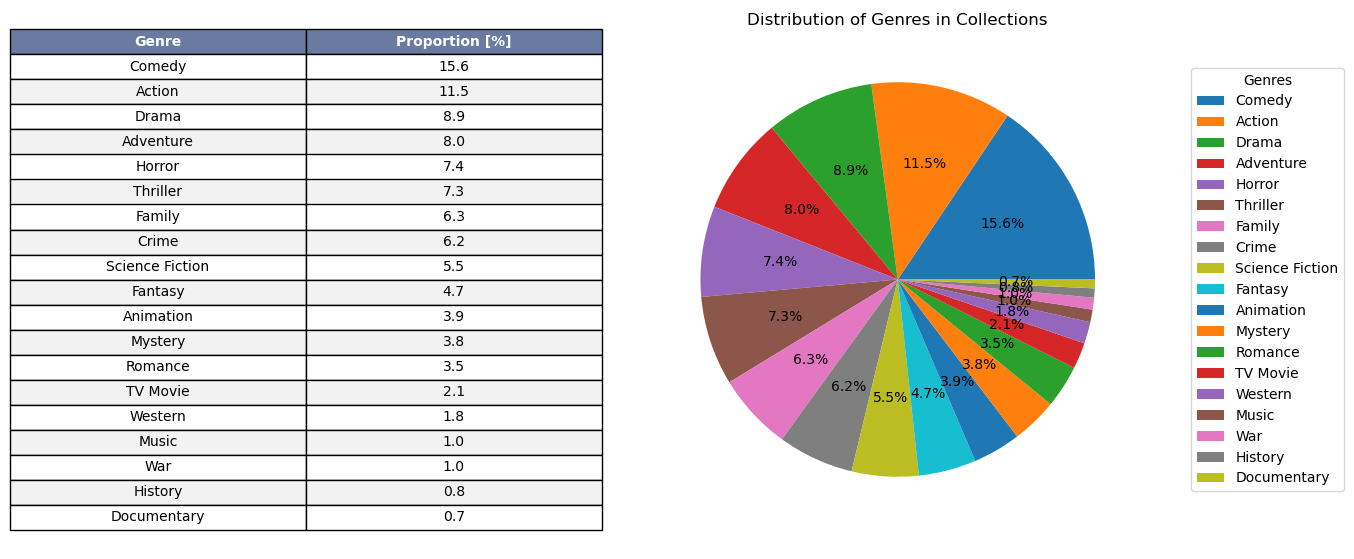

In [70]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

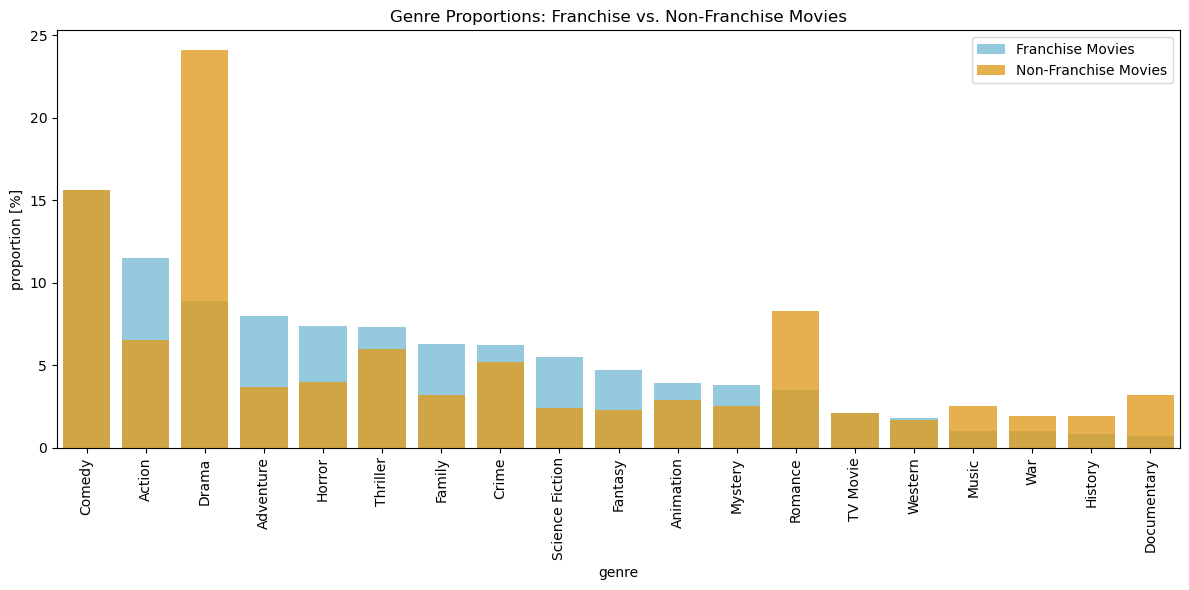

In [71]:
# Extract genres proportions for movies not in franchise, as done before
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()

## Box office 

In [72]:
franchise_revenue = franchise_df.dropna(subset=['real_revenue'])
movies_revenue = movies_df.dropna(subset=['real_revenue']) 
movies_no_franchise_revenue = movies_no_franchise_df.dropna(subset=['real_revenue'])
print(franchise_df['collection_id'].value_counts()) # This indicates that for all franhcise we have at leats 2 movies 

collection_id
564261.0    66
563999.0    58
392686.0    51
415931.0    48
435347.0    48
            ..
538387.0     2
44979.0      2
141084.0     2
338416.0     2
518611.0     2
Name: count, Length: 1592, dtype: int64


       non-franchise movies  franchise movies    all movies
count          6.929000e+03      1.256000e+03  8.400000e+03
mean           5.704675e+07      2.849195e+08  8.763865e+07
std            1.253998e+08      4.601558e+08  2.048312e+08
min            1.825894e+04      2.551028e+04  1.825894e+04
25%            3.195314e+06      2.950505e+07  3.800078e+06
50%            1.407101e+07      1.022562e+08  1.941931e+07
75%            5.269909e+07      3.386860e+08  7.437328e+07
max            3.990258e+09      6.234223e+09  5.080139e+09


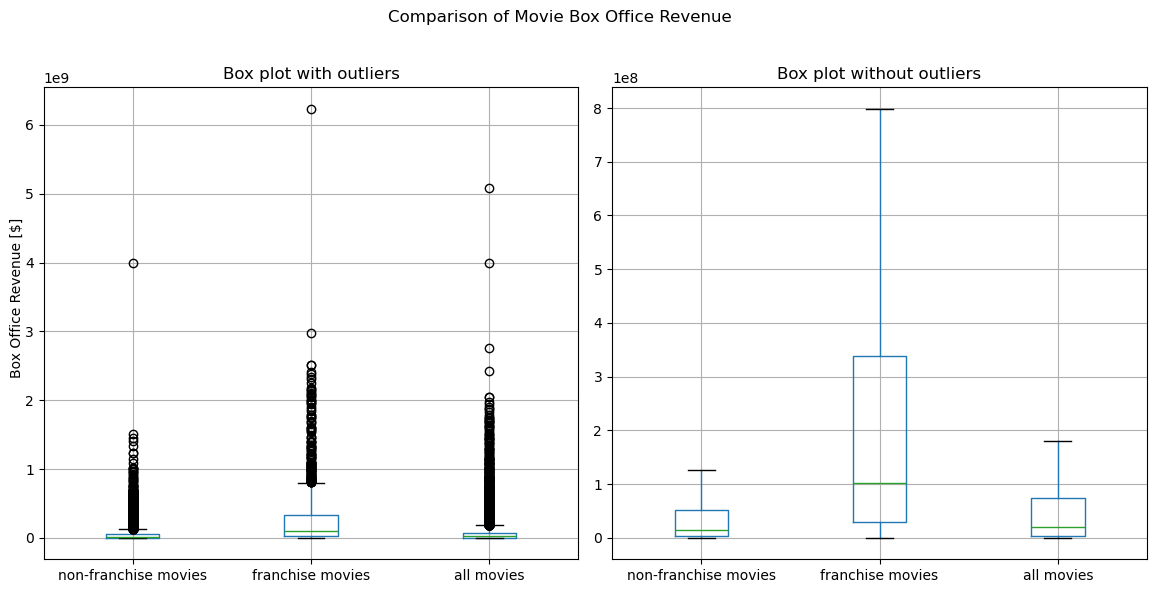

In [73]:
all_revenue= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_revenue'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_revenue'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_revenue']
        })
print(all_revenue.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_revenue.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_revenue.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue ')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

## Movie budget

       non-franchise movies  franchise movies    all movies
count          3.992000e+03      1.028000e+03  5.181000e+03
mean           4.391808e+07      8.059310e+07  4.916370e+07
std            5.133770e+07      1.041650e+08  6.168919e+07
min            9.129469e+00      1.994216e+02  9.129469e+00
25%            9.129469e+06      1.344415e+07  1.004242e+07
50%            2.738841e+07      4.033246e+07  2.738841e+07
75%            5.477681e+07      1.013913e+08  6.390628e+07
max            4.564734e+08      8.492224e+08  6.920137e+08


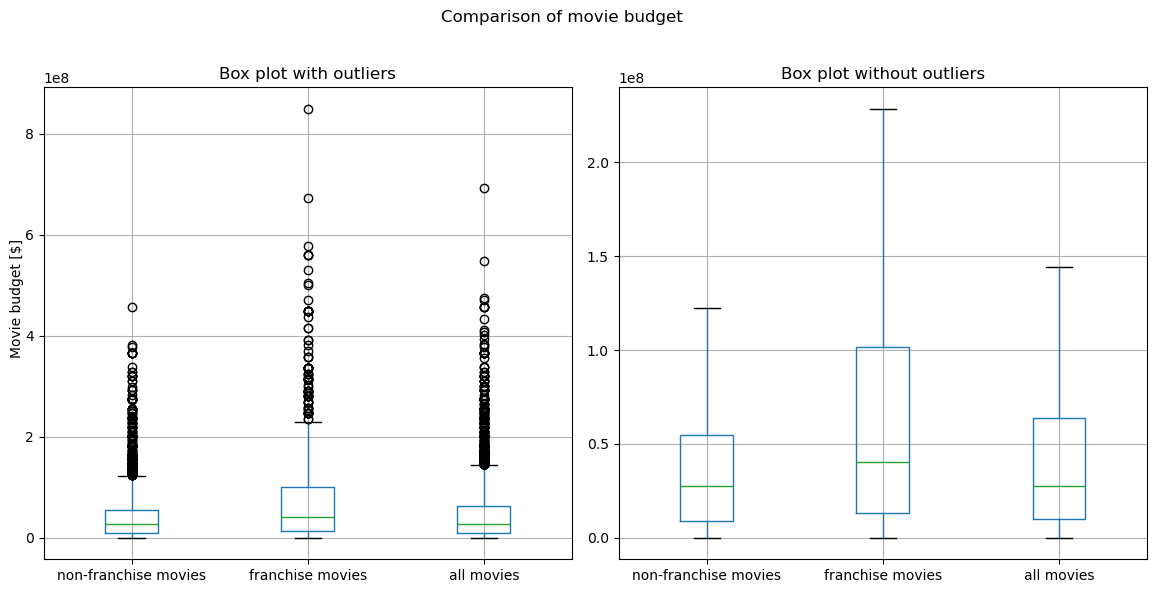

In [74]:
all_budget= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_budget'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_budget'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_budget']
        })
print(all_budget.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_budget.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_budget.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Movie budget [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of movie budget')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

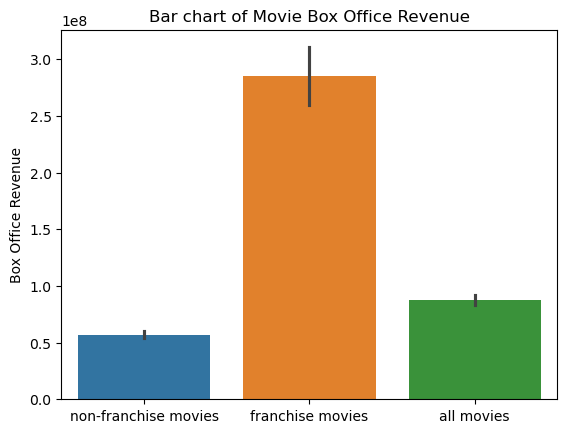

T-test Results:
T-statistic: 17.4333
P-value: 2.8144e-61
The difference in means is statistically significant (p < 0.05).


In [75]:
ax = sns.barplot(data=all_revenue)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat, p_value = stats.ttest_ind(all_revenue['franchise movies'].dropna(), all_revenue['non-franchise movies'].dropna(), equal_var=False)
print("T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("The difference in means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

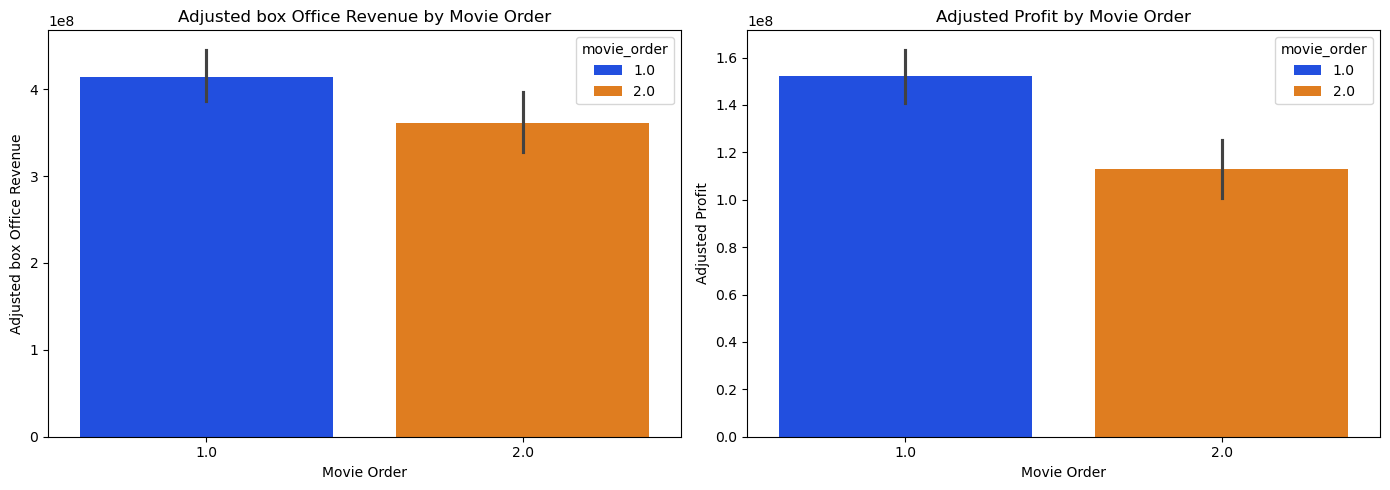

T-test Results:
T-statistic of box-office: 2.3307 ; T-statistic of profit: 4.4500
P-value of box-office: 1.9912e-02 ; P-value of profit: 9.2674e-06
The difference in box-office and profit means is statistically significant (p < 0.05).


In [76]:
# Extract the mean box office revenue for the first and second movies
first_movie_revenue = f_and_s[f_and_s['movie_order'] == 1]['real_revenue']
second_movie_revenue = f_and_s[f_and_s['movie_order'] == 2]['real_revenue']

first_movie_profit = f_and_s[f_and_s['movie_order'] == 1]['real_profit']
second_movie_profit = f_and_s[f_and_s['movie_order'] == 2]['real_profit']

# Do side by side barplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x="movie_order", y="real_revenue", data=f_and_s, palette='bright', hue='movie_order', ax=ax1)
ax1.set_ylabel('Adjusted box Office Revenue')
ax1.set_xlabel('Movie Order')
ax1.set_title('Adjusted box Office Revenue by Movie Order')

sns.barplot(x="movie_order", y="profit", data=f_and_s, palette='bright',hue='movie_order', ax=ax2)
ax2.set_ylabel('Adjusted Profit')
ax2.set_xlabel('Movie Order')
ax2.set_title('Adjusted Profit by Movie Order')

plt.tight_layout()
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat1, p_value1 = stats.ttest_ind(first_movie_revenue, second_movie_revenue, equal_var=False)
t_stat2, p_value2 = stats.ttest_ind(first_movie_profit, second_movie_profit, equal_var=False)
print("T-test Results:")
print(f"T-statistic of box-office: {t_stat1:.4f} ; T-statistic of profit: {t_stat2:.4f}")
print(f"P-value of box-office: {p_value1:.4e} ; P-value of profit: {p_value2:.4e}")
if p_value1 and p_value2 < 0.05:
    print("The difference in box-office and profit means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

## Time representation

For this part we used the released date as the main variable to analyze first the movies in the franchise collection and then the franchise as a whole

### Distribution of the release year of movies in a franchise vs the whole CMU dataset

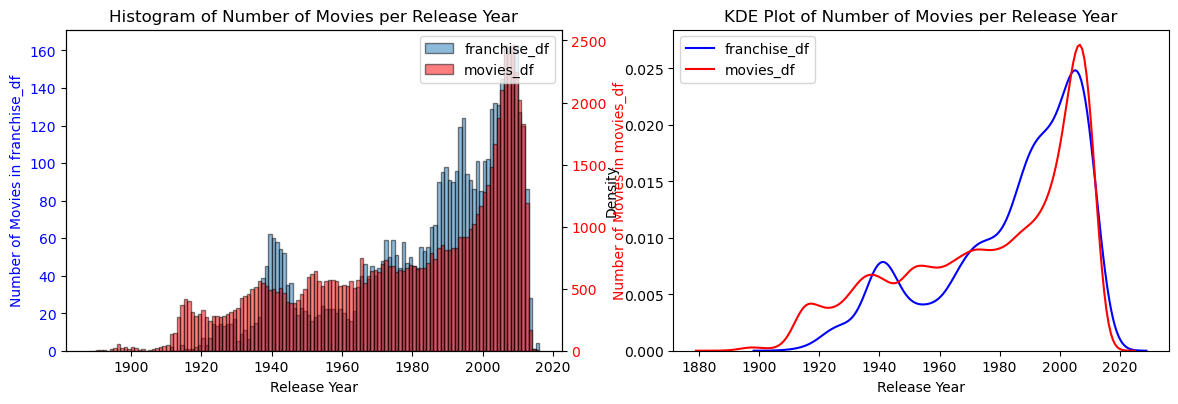

In [77]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))

# Plot the histogram for franchise_df
ax[0].hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax[0].set_xlabel('Release Year')
ax[0].set_ylabel('Number of Movies in franchise_df', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax[0].twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax[0].transAxes)


# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax[1], label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax[1], label='movies_df', color='red')

# Set labels and title
ax[1].set_xlabel('Release Year')
ax[1].set_ylabel('Density')
ax[1].set_title('KDE Plot of Number of Movies per Release Year')
ax[1].legend()

plt.show()

We observe that the subset we created from the CMU Movie dataset by extracting the franchise of at least 2 movies has more or less the same distribution of release year. Note that the CMU Movie dataset has 8% missing date. The franchise one has none since it is really necessary to know the order of the movie in a franchise, the missing release date missing were recovered.

### Franchise length and movie release frequency

The franchise_data_df is the dataframe of all the franchise and add the different characteristics: total revenue (if all the movie have a revenue), average vote of the franchise, number of movies, oldest movie release date of the franchise, most recent release date of the franchise, length and average time between the movies in a franchise.

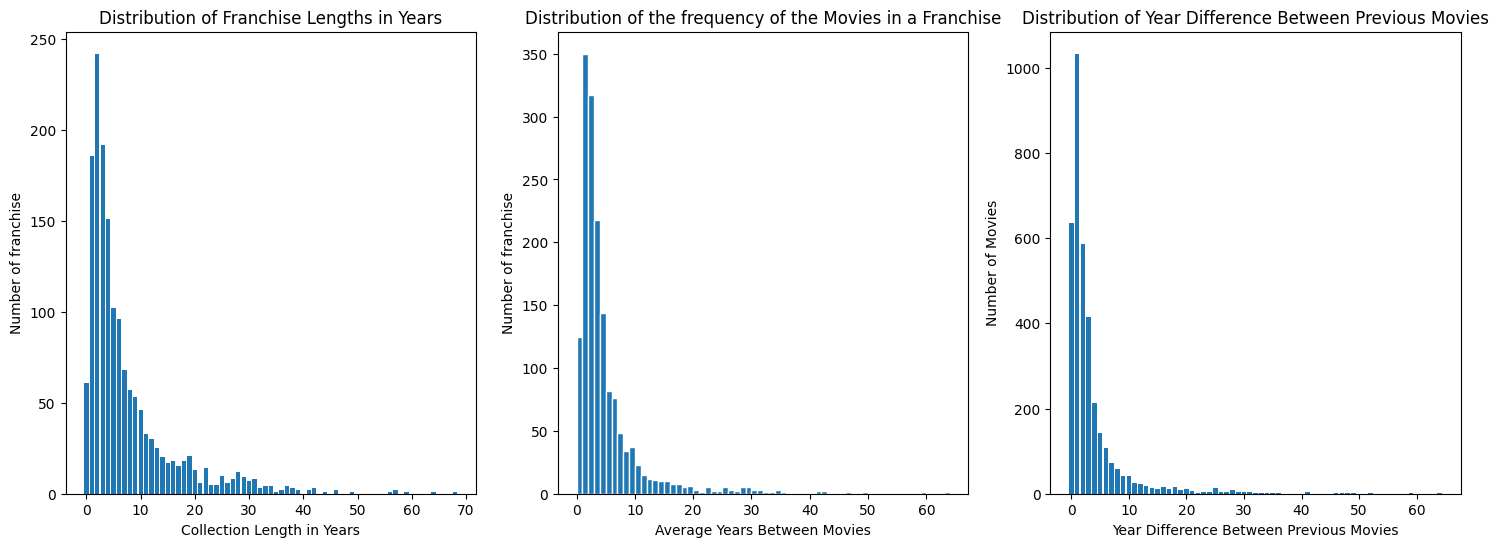

In [14]:
# Count the number of franchise with the same length
franchise_data_df_length = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_length.columns = ['franchise_length_years', 'count']

# Count the number of franchise with the same average years between movies
franchise_data_df_avbm = franchise_data_df['average_years_bt_movies'].value_counts().reset_index()
franchise_data_df_avbm.columns = ['average_years_bt_movies', 'count']
# Create bins for each year
bins = np.arange(franchise_data_df_avbm['average_years_bt_movies'].min(), franchise_data_df_avbm['average_years_bt_movies'].max() + 1, 1)

# Count the number of movie with the same year gap between the previous movie
franchise_df_ydbpm = franchise_df['years_diff_bt_pre_movies'].value_counts().reset_index()
franchise_df_ydbpm.columns = ['years_diff_bt_pre_movies', 'count']


# Plotting the bar chart
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(franchise_data_df_length['franchise_length_years'], franchise_data_df_length['count'])
ax[0].set_xlabel('Collection Length in Years')
ax[0].set_ylabel('Number of franchise')
ax[0].set_title('Distribution of Franchise Lengths in Years')

ax[1].hist(franchise_data_df['average_years_bt_movies'], bins=bins, edgecolor='white')
ax[1].set_xlabel('Average Years Between Movies')
ax[1].set_ylabel('Number of franchise')
ax[1].set_title('Distribution of the frequency of the Movies in a Franchise')

ax[2].bar(franchise_df_ydbpm['years_diff_bt_pre_movies'], franchise_df_ydbpm['count'])
ax[2].set_xlabel('Year Difference Between Previous Movies')
ax[2].set_ylabel('Number of Movies')
ax[2].set_title('Distribution of Year Difference Between Previous Movies')
#ax[2].set_yscale('log') #jsp si cest une bonne idée
plt.show()

In [17]:
# outsiders

#franchise of more thatn 20 years
long_franchise = franchise_data_df[franchise_data_df['franchise_length_years'] > 20]
print(long_franchise['collection_name'])

#franchise witha an average of more than 15 years between movies
long_average = franchise_data_df[franchise_data_df['average_years_bt_movies'] > 15]
print(long_average['collection_name'])


0                   Star Wars Collection
1               Indiana Jones Collection
11                   Predator Collection
16             The Terminator Collection
19                 James Bond Collection
                      ...               
1535          Lupin The Third Collection
1556      Goin' Down the Road Collection
1568                             Khiladi
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 128, dtype: object
57              The Space Odyssey Series
85       An American Werewolf Collection
123            Drunken Master Collection
145             Burnt by the Sun Trilogy
207               Wall Street Collection
                      ...               
1496                 Tom Cody Collection
1498       Debbie Does Dallas Collection
1556      Goin' Down the Road Collection
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 82, dtype: object

We observe that the vast majority of the franchise are in a close range with still pretty big range. We're going to use this parameter to describe the franchise in a following part.

## Countries repartition

## Character data analysis 

# Bivariate analysis 

In this part we're going to look at the possible interaction 2 features have with another, this the first step to try to observe patterns or links.

## Movie revenue and budget 

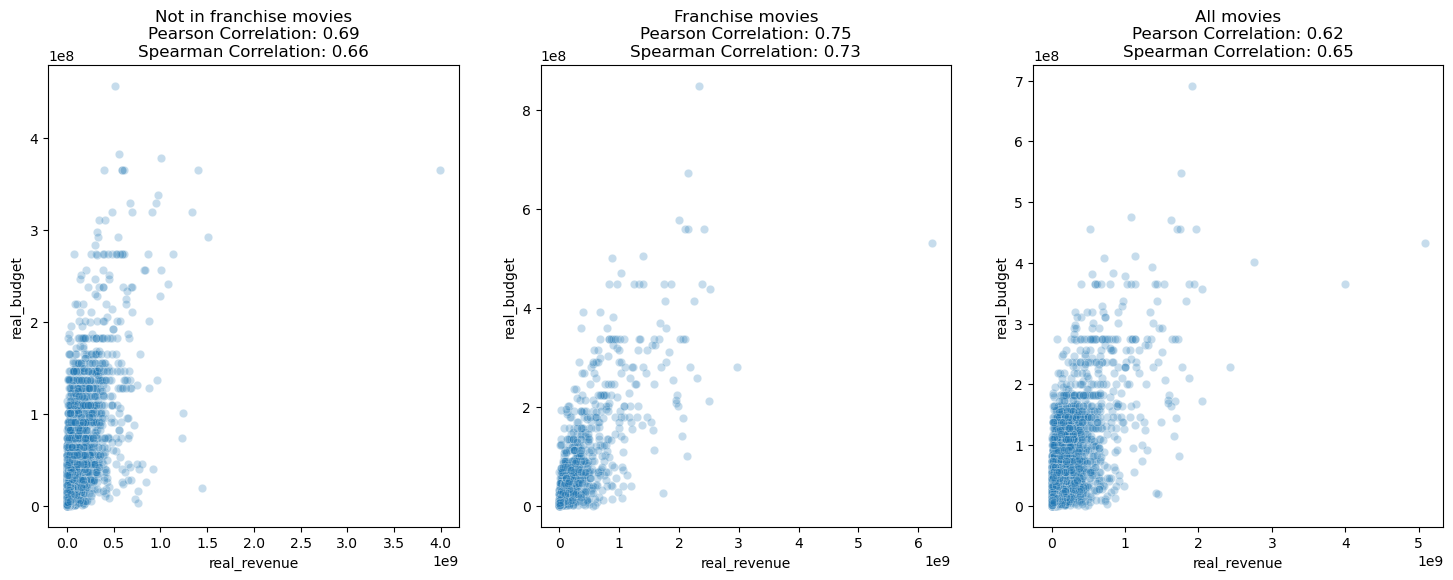

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget',data=movies_no_franchise_revenue,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=franchise_revenue,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=movies_revenue,alpha=.25, ax=axes[2])
# Calculate Pearson correlation

pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

axes[0].set_title(f'Not in franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[0,1]:.2f}')
axes[1].set_title(f'Franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[1,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[1,1]:.2f}')
axes[2].set_title(f'All movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[2,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[2,1]:.2f}');


## Genre and revenue

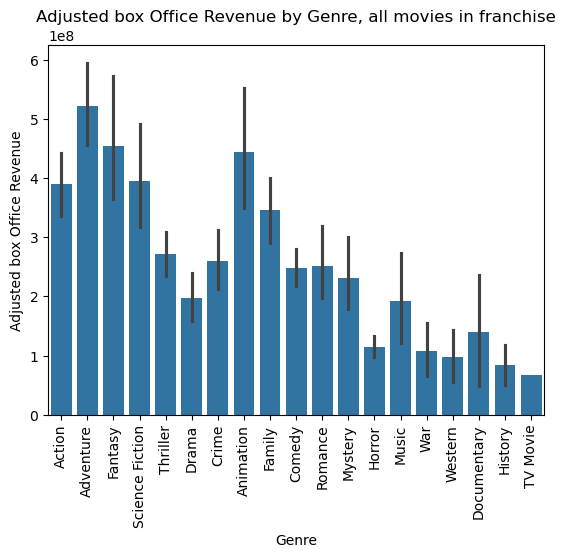

In [80]:
# Explode the genres column so that each genre gets its own row
exploded_df = franchise_df.explode('genres').reset_index(drop=True).sort_values(by='real_revenue', ascending=False)

ax = sns.barplot(x="genres", y="real_revenue", data=exploded_df)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()
#print(exploded_df.groupby('genres')['real_revenue'].describe())

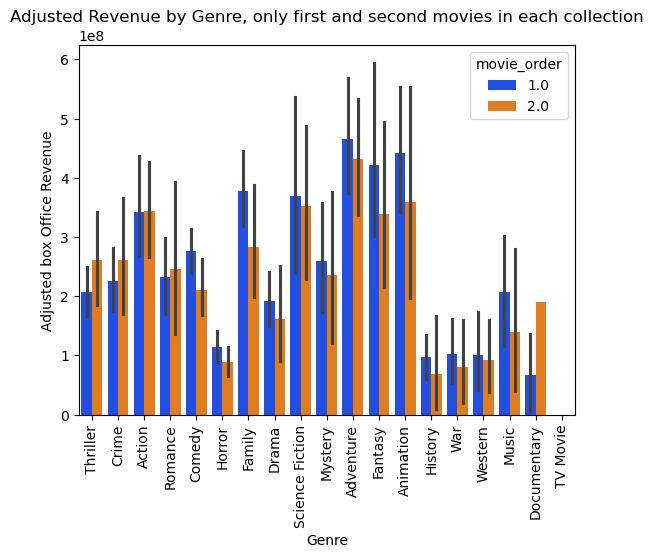

7985


In [81]:
f_and_s = exploded_df[exploded_df['movie_order'].isin([1.0, 2.0])] # First and second movies in each collection
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s.sort_values(by='real_revenue', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()
print(len(f_and_s))

Here, we notice that TV Movies don't have a barplot, as only one movie in a franchise has the real revenue, and it is the third movie in its franchise. Lack of error bars means not enough info

1409


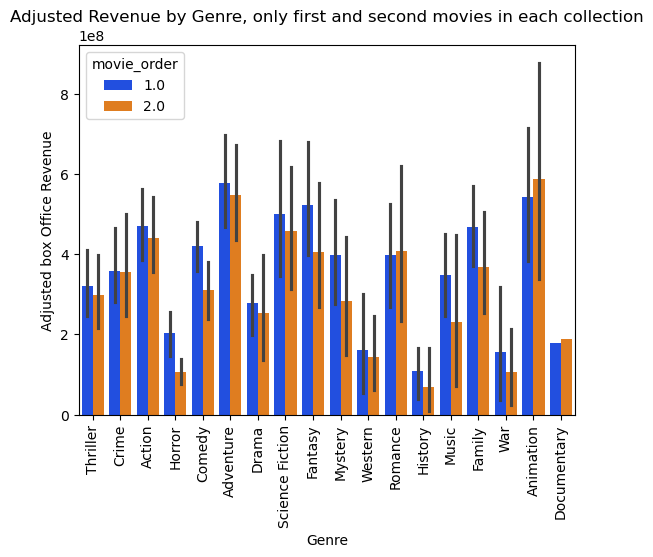

In [82]:
f_and_s_filtered = f_and_s.groupby('collection_id').filter(lambda x: x['ratio_revenue_budget'].notna().all())
print(len(f_and_s_filtered))
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s_filtered.sort_values(by='real_revenue', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()

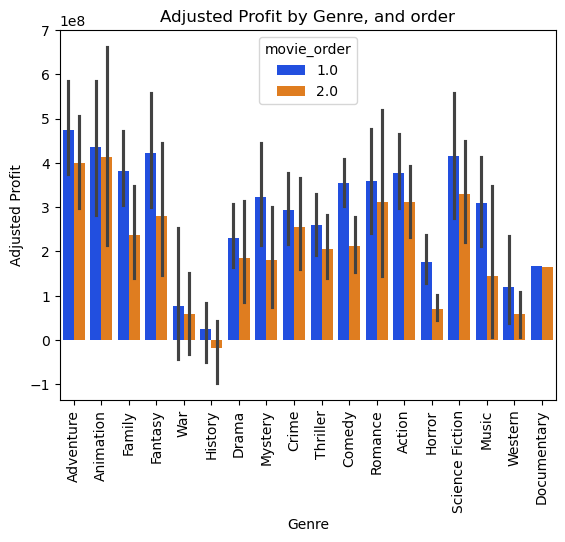

In [83]:
ax = sns.barplot(x="genres", y="real_profit", data=f_and_s_filtered.sort_values(by='real_profit', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted Profit')
plt.xlabel('Genre')
plt.title('Adjusted Profit by Genre, and order')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Same thing here

without filtering the data

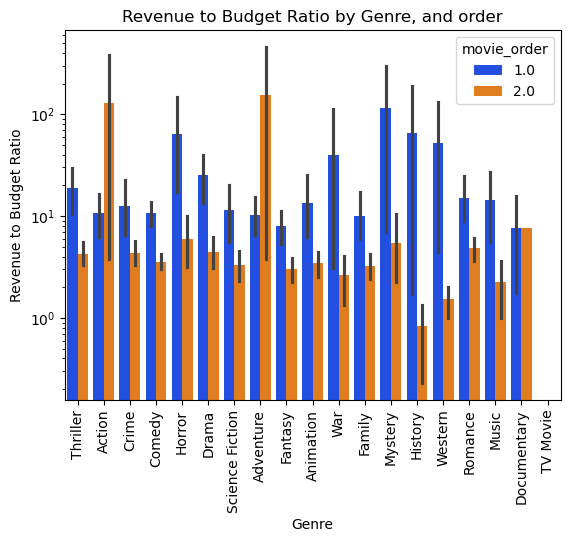

First movies :
                     Movie name    genres  ratio_revenue_budget
8871   The Blair Witch Project    Horror           4143.984983
8872   The Blair Witch Project   Mystery           4143.984983
10229      Paranormal Activity   Mystery            899.329302
10228      Paranormal Activity    Horror            899.329302
3        The Birth of a Nation     Drama            500.000000
5        The Birth of a Nation       War            500.000000
4        The Birth of a Nation   History            500.000000
1624                Open Water     Drama            420.522723
1626                Open Water    Horror            420.522723
1625                Open Water  Thriller            420.522723 
 Second movies :
                   Movie name     genres  ratio_revenue_budget
7663             Kickboxer 2  Adventure          14052.943820
7662             Kickboxer 2     Action          14052.943820
182         Dawn of the Dead     Horror             84.615385
11079  Paranormal Activi

In [89]:
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s[(f_and_s['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s[(f_and_s['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

Action and adventure movies have higher revenue/budget ratio in second movie vs in first, but very high error bars => outlier kckboxer 2, only one of the kickboxers to have ratio to revenue

So now we use filtering

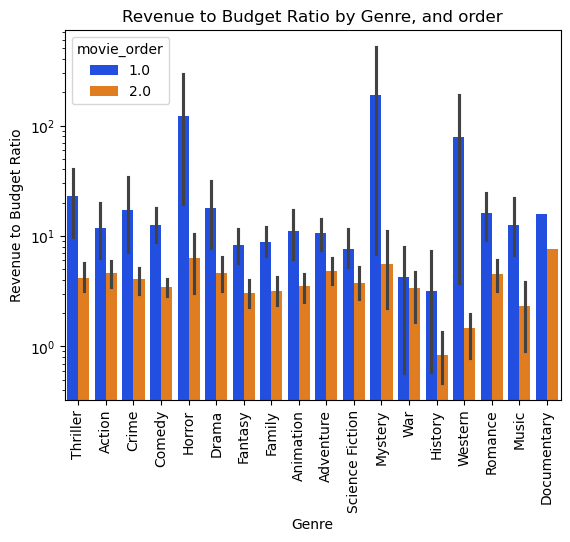

First movies :
                      Movie name    genres  ratio_revenue_budget
8872    The Blair Witch Project   Mystery           4143.984983
8871    The Blair Witch Project    Horror           4143.984983
10228       Paranormal Activity    Horror            899.329302
10229       Paranormal Activity   Mystery            899.329302
91     Night of the Living Dead    Horror            368.421053
92     Night of the Living Dead  Thriller            368.421053
736                 El Mariachi  Thriller            282.480277
734                 El Mariachi    Action            282.480277
735                 El Mariachi     Crime            282.480277
737                 El Mariachi   Western            282.480277 
 Second movies :
                                          Movie name     genres  \
182                                Dawn of the Dead     Horror   
11079                         Paranormal Activity 2    Mystery   
11078                         Paranormal Activity 2     Horror 

In [88]:
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s_filtered.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

first movie works a lot better, outlier = blair witch project

## Genre and movie order

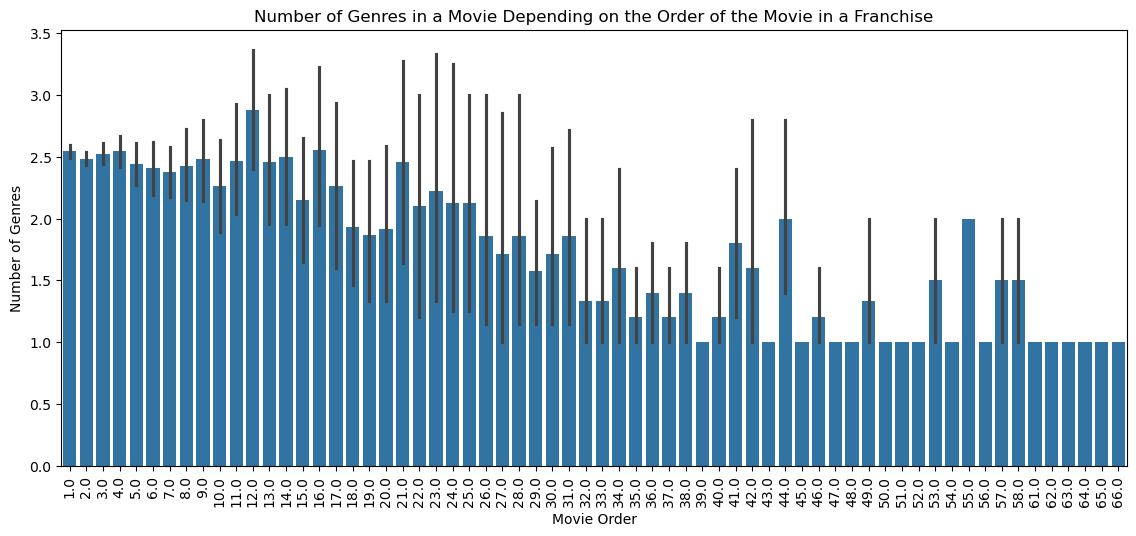

In [110]:
# Create a bar plot of the number of genres depending on the order of the movie in a franchise
drop_no_genre = franchise_df[franchise_df['num_genres'] > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_order', y='num_genres', data=drop_no_genre)

# Add labels and title
plt.xlabel('Movie Order')
plt.ylabel('Number of Genres')
plt.title('Number of Genres in a Movie Depending on the Order of the Movie in a Franchise')
# Rotate bar x-axis labels plot for better readability
plt.xticks(rotation=90)
# Adjust layout to add padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show();

We know that 75% of the franchises have between 2 and 4 movies, and here we can see that for these franchises, and for the first movies of longer franchises, the number of genres does not seem to change much. Maybe they switched though ? 
And for longer franchises, we see that the number of genres seems to decrease, and oscillate quite weirdly.
Now, let's see if the genres change between two consecutive movies

/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_46520/1749382896.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


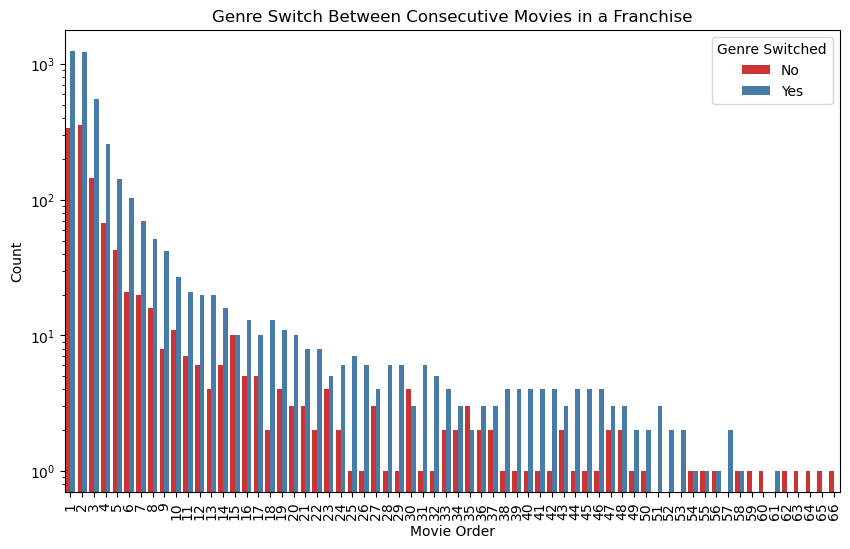

In [108]:
# Reset the index of the DataFrame
drop_no_genre = drop_no_genre.reset_index(drop=True)

# Create a new column to indicate if the genre switched between two movies in a franchise
drop_no_genre['genre_switched'] = drop_no_genre.groupby('collection_id')['genres'].apply(lambda x: x != x.shift()).reset_index(drop=True)

# Plot for every movie in the franchise
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='movie_order', hue='genre_switched', data=drop_no_genre[['movie_order', 'genre_switched']].astype(int), palette='Set1', ax=ax)
ax.set_xlabel('Movie Order')
ax.set_ylabel('Count')
ax.set_title('Genre Switch Between Consecutive Movies in a Franchise')
ax.legend(title='Genre Switched', labels=['No', 'Yes'])
ax.set_yscale('log')
# Ensure x-axis labels are integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_46520/536437533.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


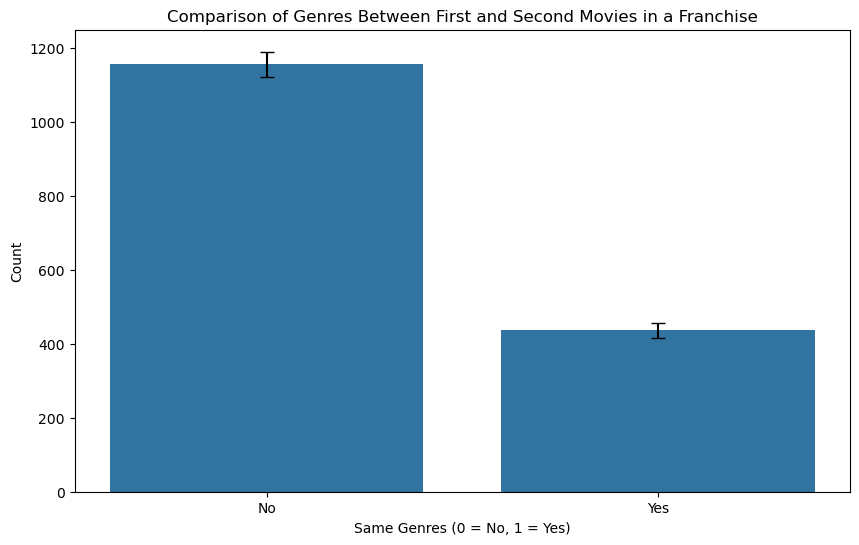

In [ ]:
# Filter the DataFrame to include only the first and second movies in each franchise
first_and_second_movies = drop_no_genre[drop_no_genre['movie_order'].isin([1, 2])]

# Pivot the DataFrame to have one row per franchise and columns for the genres of the first and second movies
pivot_df = first_and_second_movies.pivot(index='collection_id', columns='movie_order', values='genres')

# Create a new column to indicate if the genres are the same between the first and second movies
pivot_df['same_genres'] = pivot_df[1] == pivot_df[2]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Calculate the error bars
error_bars = pivot_df['same_genres'].astype(int).value_counts().apply(lambda x: math.sqrt(x))

# Plot with error bars
sns.countplot(x=pivot_df['same_genres'].astype(int), ax=ax)
ax.errorbar(x=[0, 1], y=pivot_df['same_genres'].astype(int).value_counts(), yerr=error_bars, fmt='none', c='black', capsize=5)
ax.set_xlabel('Same Genres (0 = No, 1 = Yes)')
ax.set_ylabel('Count')
ax.set_title('Comparison of Genres Between First and Second Movies in a Franchise')
ax.set_xticklabels(['No', 'Yes'])

plt.show()
print(pivot_df)

ajouter ça si possible dans une lin reg / trees etc, mais attention ! certains films ont 0 genres, mais n'ont pas le ratio non plus !
j'ai ajouté dans utils !

## Budget and revenue

## Average revenue of a franchise and length of a franchise, frequency and number of movie 

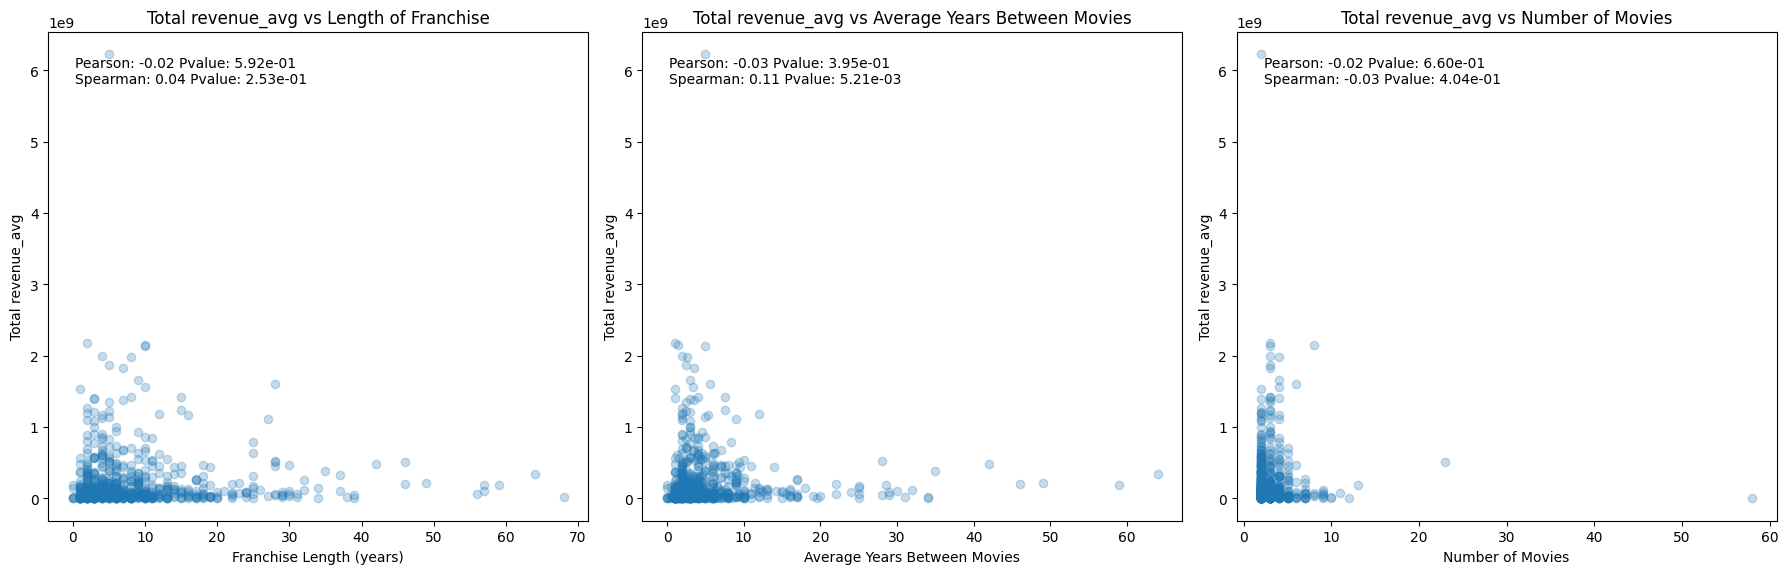

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of total revenue_avg vs length of a franchise
axes[0].scatter(franchise_data_df['franchise_length_years'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[0].set_title('Total revenue_avg vs Length of Franchise')
axes[0].set_xlabel('Franchise Length (years)')
axes[0].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs average years between movies
axes[1].scatter(franchise_data_df['average_years_bt_movies'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[1].set_title('Total revenue_avg vs Average Years Between Movies')
axes[1].set_xlabel('Average Years Between Movies')
axes[1].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs number of movies in the franchise
axes[2].scatter(franchise_data_df['movie_count'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[2].set_title('revenue_avg vs Number of Movies')
axes[2].set_xlabel('Number of Movies')
axes[2].set_ylabel('Total revenue_avg')

plt.tight_layout()

# Calculate Pearson and Spearman correlations
pearson_corr_length = stats.pearsonr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])
spearman_corr_length = stats.spearmanr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])

pearson_corr_average = stats.pearsonr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])
spearman_corr_average = stats.spearmanr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])

pearson_corr_count = stats.pearsonr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])
spearman_corr_count = stats.spearmanr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])


# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_length.statistic:.2f} Pvalue: {pearson_corr_length.pvalue:.2e}\nSpearman: {spearman_corr_length.statistic:.2f} Pvalue: {spearman_corr_length.pvalue:.2e}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_average.statistic:.2f} Pvalue: {pearson_corr_average.pvalue:.2e}\nSpearman: {spearman_corr_average.statistic:.2f} Pvalue: {spearman_corr_average.pvalue:.2e}',
             transform=axes[1].transAxes, verticalalignment='top')

axes[2].text(0.05, 0.95, f'Pearson: {pearson_corr_count.statistic:.2f} Pvalue: {pearson_corr_count.pvalue:.2e}\nSpearman: {spearman_corr_count.statistic:.2f} Pvalue: {spearman_corr_count.pvalue:.2e}',
             transform=axes[2].transAxes, verticalalignment='top')

plt.show()

We don't observe a significant correlation, but there seems to be a range where the high budget movies lays in.

## Box office of a movie and the average vote of a movie vs the year difference between the movies

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_11599/2915503090.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  franchise_df_temp['years_diff_bt_pre_movies'].fillna(-1, inplace=True)


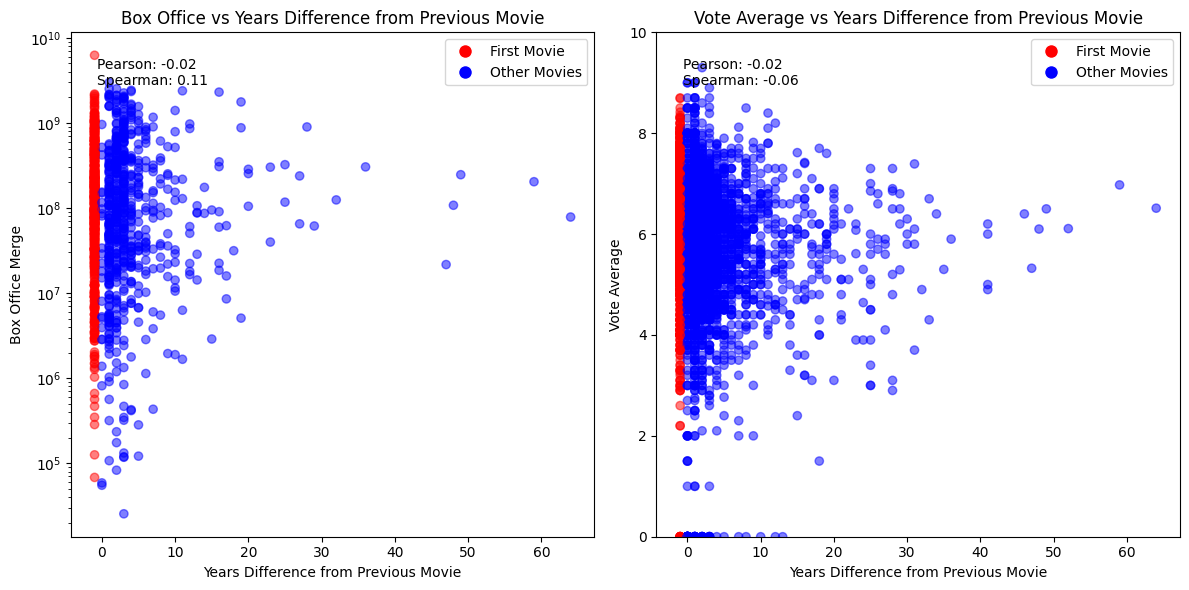

In [28]:
# Create a copy of the franchise data since modification will be made
franchise_df_temp = franchise_df.copy()

# Replace NaN values in 'years_diff_bt_pre_movies' with -1
franchise_df_temp['years_diff_bt_pre_movies'].fillna(-1, inplace=True)

# Create a color map for the scatter plot
colors = franchise_df_temp['years_diff_bt_pre_movies'].apply(lambda x: 'red' if x == -1 else 'blue')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of years difference vs box office merge
axes[0].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['real_revenue'], c=colors, alpha=0.5)
axes[0].set_title('Box Office vs Years Difference from Previous Movie')
axes[0].set_xlabel('Years Difference from Previous Movie')
axes[0].set_ylabel('Box Office Merge')
axes[0].set_yscale('log')

# Scatter plot of years difference vs vote average
axes[1].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['vote_average'], c=colors, alpha=0.5)
axes[1].set_title('Vote Average vs Years Difference from Previous Movie')
axes[1].set_xlabel('Years Difference from Previous Movie')
axes[1].set_ylabel('Vote Average')
axes[1].set_ylim(0, 10)

# Add legend to the plot
first_movie_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='First Movie')
other_movies_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Movies')
axes[0].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')
axes[1].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')

plt.tight_layout()

# Filter out rows where 'years_diff_bt_pre_movies' is -1
filtered_franchise_df_temp = franchise_df_temp[franchise_df_temp['years_diff_bt_pre_movies'] != -1]

# Calculate Pearson and Spearman correlations
pearson_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='spearman').iloc[0, 1]

pearson_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='spearman').iloc[0, 1]

# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_box_office:.2f}\nSpearman: {spearman_corr_years_diff_box_office:.2f}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_vote_average:.2f}\nSpearman: {spearman_corr_years_diff_vote_average:.2f}', 
             transform=axes[1].transAxes, verticalalignment='top')

plt.show()


Note that the first movies were assigned the value -1 to differentiate them from the rest of the movies but still have them on the plot (they are not taking into account for the correlation). We observe no significant correlation for both 

# Supervised learning

## First and Second movie

### Linear Regression 

As a first test to find the feature that have a significant impact on the successfulness of a movie that we chose to represent with the ratio of revenue over the budget in order to be more neutral the movie vast range of budget and also since the revenue has a significant correlation with the budget, it would have been useless to try to directly use revenue as a predictor.

In [32]:
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

regre=get_1_2_movies(franchise_df)

def has_genre_diff_strings(genre_1, genre_2):
    if pd.isna(genre_1) or pd.isna(genre_2):  # Handle NaN
        return False  # No comparison possible
    set_1 = set(genre_1.split(", "))  # Convert string to set
    set_2 = set(genre_2.split(", "))  # Convert string to set
    return set_1 != set_2  # Return True if the sets are different

# Apply the function row-wise
regre['genre_diff'] = regre.apply(
    lambda row: has_genre_diff_strings(row['genres_1'], row['genres_2']), axis=1
)

regre=pd.get_dummies(regre, columns=['genre_diff'], drop_first=True)

regre=regre.dropna(subset=['real_profit_1'])
regre=regre.dropna(subset=['ratio_revenue_budget_2'])



# Define the features and the label
X = regre.drop(columns=['vote_count_2','Movie name_1','Movie name_2','Wikipedia movie ID_1','Wikipedia movie ID_2','real_profit_2','real_revenue_2','real_profit_1','ratio_revenue_budget_1','ratio_revenue_budget_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2','vote_average_2'])

y = regre['ratio_revenue_budget_2']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the features
X_train_std = StandardScaler().fit_transform(X_train)

X_test_std = StandardScaler().fit(X_train).transform(X_test)


# Add a constant to the features (intercept term)
X_train_std = sm.add_constant(X_train_std)

# Fit the regression model
model = sm.OLS(Y_train, X_train_std).fit()

# Print the summary of the regression model
print(model.summary())

results_table = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.params[1:],
    'P-value': model.pvalues[1:]
})
print(results_table)

                              OLS Regression Results                              
Dep. Variable:     ratio_revenue_budget_2   R-squared:                       0.508
Model:                                OLS   Adj. R-squared:                  0.235
Method:                     Least Squares   F-statistic:                     1.862
Date:                    Wed, 18 Dec 2024   Prob (F-statistic):            0.00115
Time:                            14:48:24   Log-Likelihood:                -635.09
No. Observations:                     200   AIC:                             1414.
Df Residuals:                         128   BIC:                             1652.
Df Model:                              71                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [38]:
results_table.sort_values(by='P-value', ascending=True).head(15)

Feature   Coefficient   P-value
x14          collection_size_1  2.951095e+00  0.000042
x51           genre_2_thriller -2.365330e+00  0.005683
x5                  run_time_2  3.440649e+00  0.008969
x39             genre_2_comedy -4.368380e+00  0.015063
x98   tmdb_origin_country_1_se  9.256835e-01  0.018471
x153  tmdb_origin_country_2_se  9.256835e-01  0.018471
x91   tmdb_origin_country_1_no  9.256835e-01  0.018471
x13               num_genres_2 -1.949715e+00  0.019967
x11              real_budget_2 -3.152875e+00  0.021011
x61   tmdb_origin_country_1_br  2.536977e-15  0.037937
x34            genre_1_western  1.291732e+00  0.075806
x4                  run_time_1 -2.559885e+00  0.077441
x19             genre_1_comedy  3.005265e+00  0.088940
x31           genre_1_thriller  1.372619e+00  0.103234
x48            genre_2_mystery -1.488112e+00  0.120547

i tried to do it again with the first and second movie dataset but it gives wierd results

### Tree  --> WE need a non continuous variable a new feature such as good or not good 2 nd movie 

In [ ]:
# %%
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

# %%
def count_genre_diff(curr, prev):
    if curr is None or prev is None:  # Handle NaN or None
        return 0
    curr_set, prev_set = set(curr), set(prev)
    return len(curr_set.symmetric_difference(prev_set))  # Count differences

# Apply the function while ensuring sorting
franchise_df['genre_diff'] = (
    franchise_df.groupby('collection_id', group_keys=False)
    .apply(
        lambda group: group.sort_values(by='movie_order')  # Sort locally
        .assign(
            genre_diff=lambda x: [
                count_genre_diff(curr, prev)
                for curr, prev in zip(x['genres'], x['genres'].shift(1))
            ]
        )
    )['genre_diff']  # Extract the 'genre_diff' column
    .reset_index(drop=True)  # Reset index to avoid misalignment
)

# difference relative de genre
franchise_df['genre_diff_rel'] = franchise_df['genre_diff'] / franchise_df['genres'].apply(len)

# %%
# analysis of the difference between the first en second movies
fsm_df = franchise_df[(franchise_df['movie_order'] == 1) | (franchise_df['movie_order'] == 2)]
fsm_df = fsm_df[['Movie name','collection_name','movie_order','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies','genre_diff','genre_diff_rel']]
fsm_df.sort_values(by='movie_order',inplace=True)
fsm_df['diff_profit_1_2'] = fsm_df.groupby('collection_name')['real_profit'].diff()
fsm_df['diff_budget_1_2'] = fsm_df.groupby('collection_name')['real_budget'].diff()
fsm_df['diff_revenue_1_2'] = fsm_df.groupby('collection_name')['real_revenue'].diff()
sm_df = fsm_df[fsm_df['movie_order'] == 2]
sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']
sm_df=sm_df[sm_df['diff_profit_1_2'].notna()]  
X = sm_df[['real_budget','years_diff_bt_pre_movies','diff_budget_1_2','genre_diff']]
X = pd.get_dummies(X, columns=['genre_diff'], drop_first=True)

Y = sm_df['profit_over_budget'] 



/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_18093/3625562519.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/pk/zbd7z2k51w5_w89mv7brxxzm0000gn/T/ipykernel_18093/3625562519.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']


In [ ]:
# %%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [ ]:
# Define the bins and labels
bins = [-np.inf, -1, 0, 1, 2, 5, 10, np.inf]
labels = ['Very Low', 'Low', 'Below Average', 'Average', 'Above Average', 'High', 'Very High']

# Transform Y into non-continuous values
Y_binned = pd.cut(y_train, bins=bins, labels=labels)

# Print the transformed Y
print(Y_binned)
print(y_train)

136         Very High
247     Below Average
654     Below Average
484     Below Average
50          Very High
            ...      
530     Below Average
4577    Below Average
427     Above Average
927     Below Average
364     Below Average
Name: profit_over_budget, Length: 199, dtype: category
Categories (7, object): ['Very Low' < 'Low' < 'Below Average' < 'Average' < 'Above Average' < 'High' < 'Very High']
136     12.316484
247      0.066655
654      0.492085
484      0.300642
50      12.902139
          ...    
530      0.185794
4577     0.591640
427      2.758881
927      0.653369
364      0.060665
Name: profit_over_budget, Length: 199, dtype: float64


In [ ]:
# %%
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier(random_state=42)

decision_tree_classifier.fit(X_train, Y_binned)

y_test_pred_rf = decision_tree_classifier.predict(X_test)

#acc = accuracy_fn(y_test, y_test_pred_rf)
depth = decision_tree_classifier.get_depth()
#print(f"Accuracy: {acc}, Depth: {depth}")   

# Visualize the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 100))
plot_tree(decision_tree_classifier, filled=True)
plt.show()


## KNN regression of franchise that have both a average revenue and a average budget

The revenue and budget of a franchise was calculated using the known values of movies in the franchise and was average on the number of movies that had a value. This was done in order to maximize the number of franchise for the analysis, but it can create a bias since its assuming that movies that don't have values must have had a similar revenue and budget.

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_29772/4201342542.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

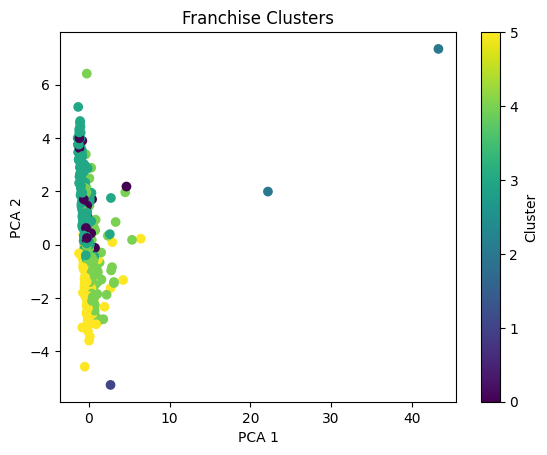

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd



KNN_data = get_franchise_data(franchise_df)
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(KNN_data['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(KNN_data['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, country_df], axis=1)

# Separate the franchise with a ratio of revenue over budget and the ones that don't
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])
KNN_data_na = KNN_data[KNN_data['ratio_rb'].isna()]

# Load and preprocess dat
data = KNN_data_no_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region'])


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_no_na['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_no_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

## Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
    Cluster                        collection_name
19        1                  James Bond Collection
34        2  USA: Land of Opportunities Collection
150       2              The Millennium Collection


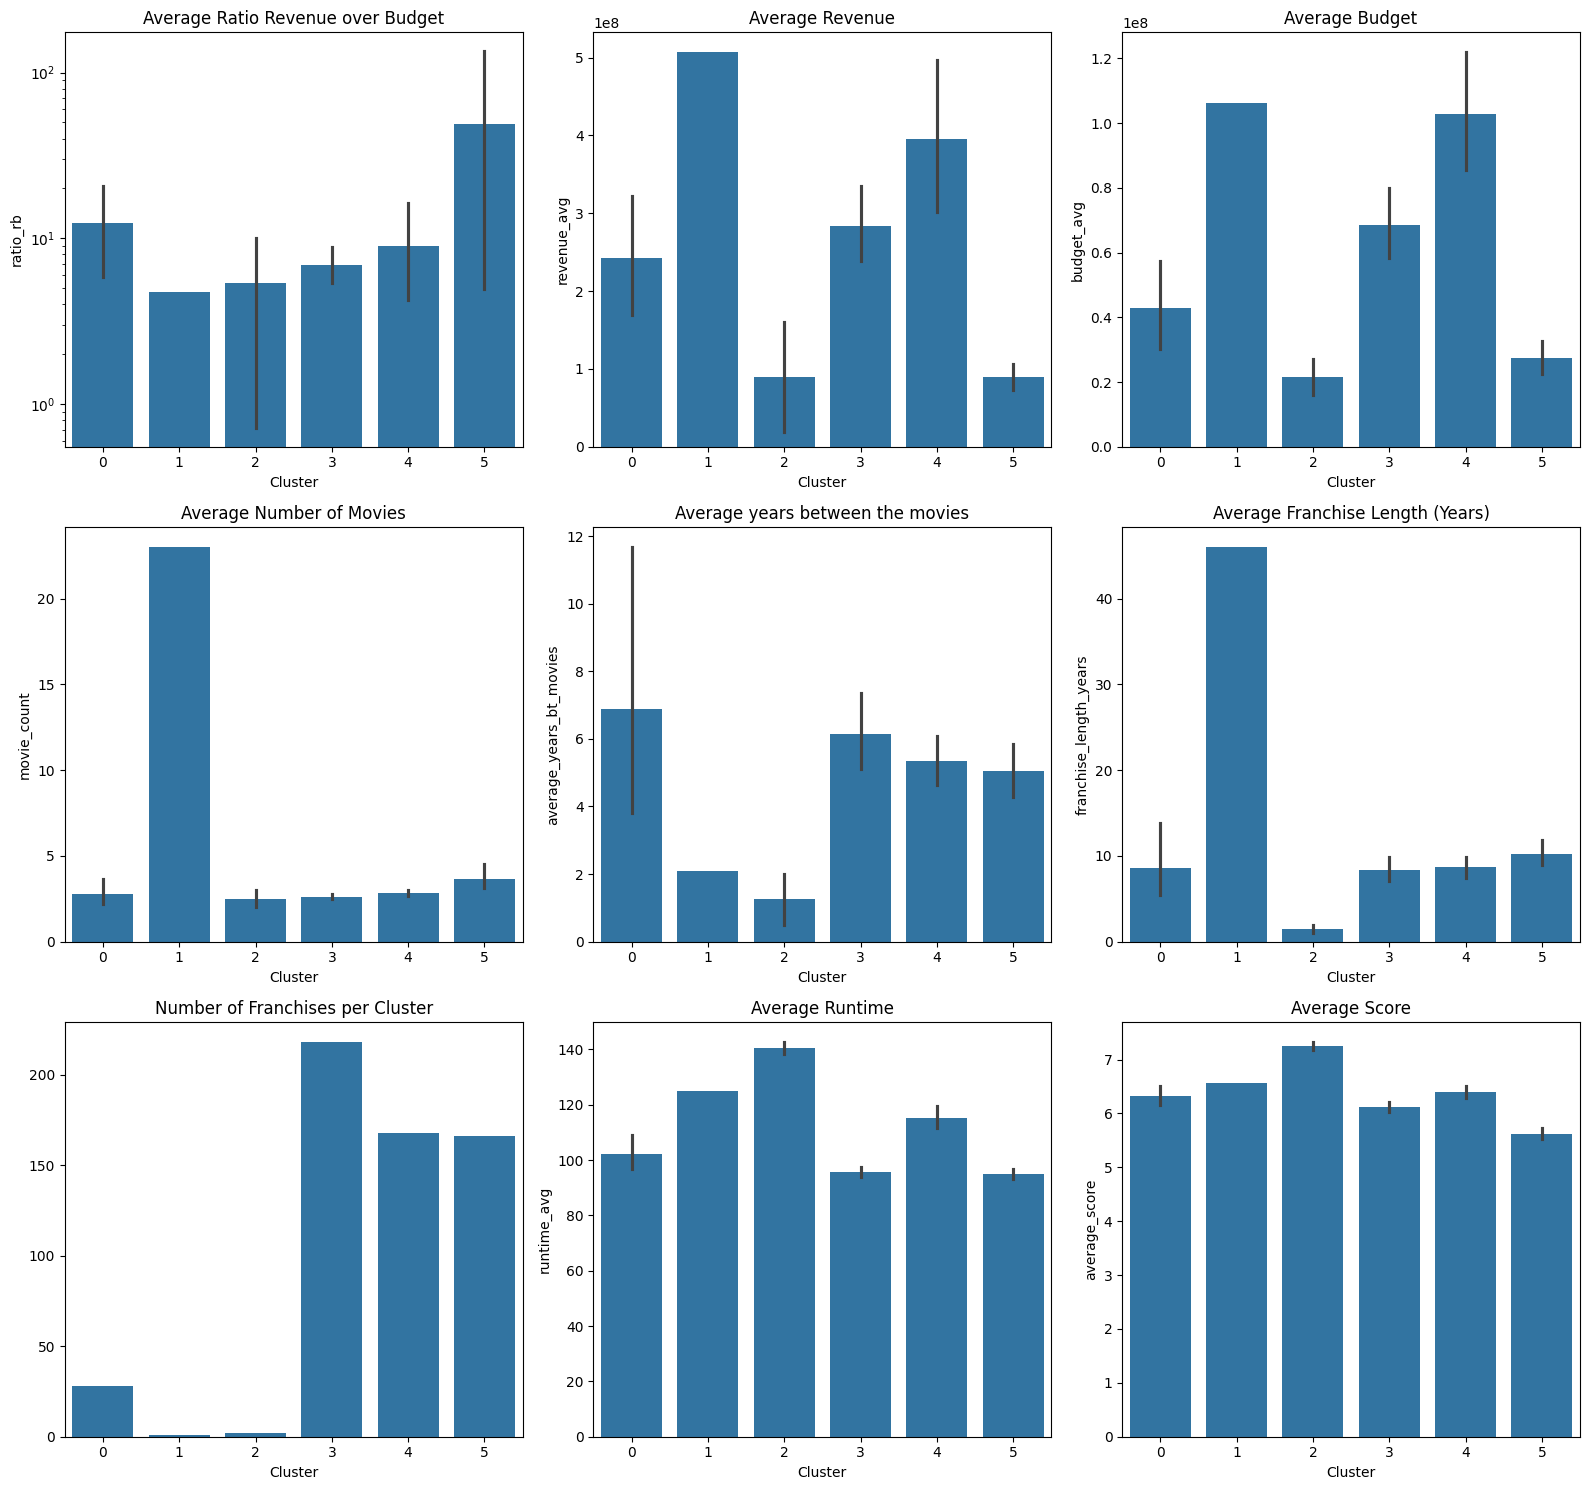

In [8]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 0)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_data_no_na[~KNN_data_no_na['Cluster'].isin(KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(3, 3, figsize=(16, 15))
sns.barplot(x='Cluster', y='ratio_rb', data=KNN_data_filt, ax=axs[0,0])
axs[0,0].set_title('Average Ratio Revenue over Budget')
axs[0,0].set_yscale('log')
sns.barplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Revenue')
sns.barplot(x='Cluster', y='budget_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Budget')
sns.barplot(x='Cluster', y='movie_count', data=KNN_data_filt, ax=axs[1,0])
axs[1,0].set_title('Average Number of Movies')
sns.barplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt, ax=axs[1,1])
axs[1,1].set_title('Average years between the movies')
sns.barplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt, ax=axs[1,2])
axs[1,2].set_title('Average Franchise Length (Years)')
sns.barplot(x=KNN_data_no_na['Cluster'].value_counts().index, y=KNN_data_no_na['Cluster'].value_counts().values, ax=axs[2,0])
axs[2,0].set_title('Number of Franchises per Cluster')
sns.barplot(x='Cluster', y='runtime_avg', data=KNN_data_filt, ax=axs[2,1])
axs[2,1].set_title('Average Runtime')
sns.barplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[2,2])
axs[2,2].set_title('Average Score')


plt.tight_layout()
plt.show()



By doing different number of cluster we quickly observe that it can pretty easily make 4 clusters with a lot of franchises, the James Bonds' franchise is always alone and there are some other outliers that varies slightly when the number of cluster is increase, but 6 clusters made interesting results, so we're going to stick with that. 

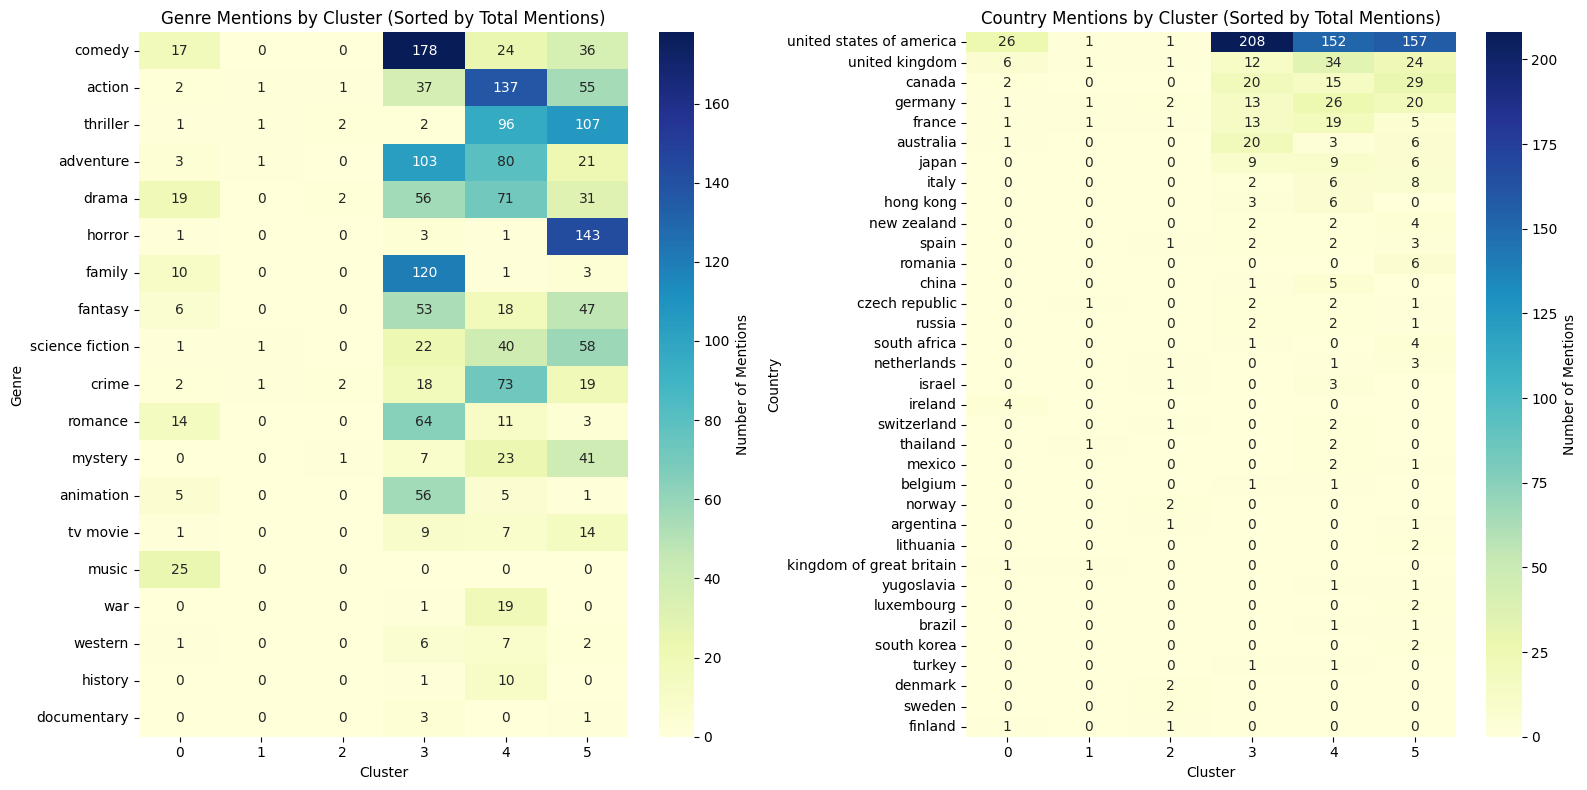

In [9]:
# Summing country mentions by cluster
country_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]
# remove the country that are mentionned only once
country_sums = country_sums.loc[:, country_sums.sum() > 1]


# Summing genre mentions by cluster
genre_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums = genre_sums.loc[:, genre_sums.sum().sort_values(ascending=False).index]


# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[1].set_title('Country Mentions by Cluster (Sorted by Total Mentions)')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Country')
plt.tight_layout()
plt.show()



### Summary by cluster

Cluster 1:

In [10]:
KNN_data_no_na[KNN_data_no_na['Cluster']==0]['collection_name']

75                      Bridget Jones Collection
77                      Wayne's World Collection
138              The Land Before Time Collection
220                          Fantasia Collection
256                     Dirty Dancing Collection
258                            Grease Collection
259                           Step Up Collection
296               High School Musical Collection
330                          Breakin' Collection
399                        Sister Act Collection
421               Save the Last Dance Collection
446                The Blues Brothers Collection
569             All Dogs Go to Heaven Collection
590                             Honey Collection
625                    Stomp the Yard Collection
642           Alvin and the Chipmunks Collection
736                       StreetDance Collection
784                        Billy Jack Collection
793                      Center Stage Collection
853                       Tony Manero Collection
880                 

This cluster is the cluster of the musical, mostly produces by the United States, they have a pretty good ratio of budget over revenues, and they never have more that 3-4 movies.

Cluster 2:

In [11]:
KNN_data_no_na[KNN_data_no_na['Cluster']==1]['collection_name']

19    James Bond Collection
Name: collection_name, dtype: object

The second cluster is the James Bond one, it is a big outlier that was already noticed previously and confirm again. It looks like no other franchise can be compared to it. It is around 25 movies that have been produced in 45 years, so around a movie each 2 years, and it has an average revenue that is big compared to other franchise. I think what makes this franchise unique is that its timeless.

Cluster 3:

In [ ]:
KNN_data_no_na[KNN_data_no_na['Cluster']==2]['collection_name']

34     USA: Land of Opportunities Collection
150                The Millennium Collection
Name: collection_name, dtype: object

This is the other cluster with outliers, I personally never heard of those movies, but it looks like it got excellent review on tmbd and the movie runtime is longer than average. We also observe that one of those two franchise must have not really work out in the end since a ratio of revenue over budget is pretty low.

Cluster 4:

In [ ]:
pd.set_option('display.max_rows', 500)  # Set a higher row limit
KNN_data_filt[KNN_data_filt['Cluster'] == 3]['collection_name']

7                          Back to the Future Collection
25                              Austin Powers Collection
30               Teenage Mutant Ninja Turtles Collection
38                                      Shrek Collection
43               Asterix & Obelix Live-action Collection
48                               American Pie Collection
50                               Ghostbusters Collection
52                                Ace Ventura Collection
53                               Dr. Dolittle Collection
56                                Scary Movie Collection
63                                    Ice Age Collection
66                             The Karate Kid Collection
70                           An American Tail Collection
71                                     Casper Collection
81                                 Free Willy Collection
83                           Crocodile Dundee Collection
84                             Police Academy Collection
86                             

This is one of the first really big cluster, it looks like its mostly teenage movies, animated movies, disneys and family sitcom. The main genre is comedy and 

Cluster 5:

In [ ]:
KNN_data_filt[KNN_data_filt['Cluster'] == 4]['collection_name']

0                             Star Wars Collection
1                         Indiana Jones Collection
2                 The Lord of the Rings Collection
4        Star Trek: The Original Series Collection
5                         The Godfather Collection
6                       The Dark Knight Collection
8              Pirates of the Caribbean Collection
9                               Ocean's Collection
10                        Jurassic Park Collection
11                             Predator Collection
16                       The Terminator Collection
18                           Spider-Man Collection
22                                X-Men Collection
24                        Lethal Weapon Collection
26                         Harry Potter Collection
28                             Die Hard Collection
29                                Rocky Collection
31                                Zorro Collection
32        Planet of the Apes (Original) Collection
33                            T

This cluster looks like its mostly action movies and blockbuster hence it is also the pretty high budget franchise.

cluster 6:

In [ ]:
KNN_data_filt[KNN_data_filt['Cluster'] == 5]['collection_name']

13                                 Cube Collection
20                                  Saw Collection
21                                Blade Collection
23          The Pink Panther (Original) Collection
27                  28 Days/Weeks Later Collection
35                            Evil Dead Collection
37                           The Grudge Collection
40                           Underworld Collection
42                                 Jaws Collection
45                               Scream Collection
51                     World of Watches Collection
54      I Know What You Did Last Summer Collection
61                           Highlander Collection
62                                Alien Collection
67            A Nightmare on Elm Street Collection
72                    Final Destination Collection
73                           Hellraiser Collection
74         The Hills Have Eyes (Reboot) Collection
79                         The Prophecy Collection
85                 An American 

This cluster is the clusters of the horror and thrillers movies, we can see that it has most of the time smaller budget but can have a ratio that can be really high depending on the franchise.

To conclude this part it looks like the pattern we were looking for is kind of hard to define, it looks like the cluster have mostly been separated by their genre which looks like its link to the average budget of the franchise. We were thinking that the successfulness of a franchise could be seen in the ratio of the revenue over the budget but the results don't give a clear answer.

It also looks like analyzing the franchise has a whole makes it difficult to quantify what is going to make a good franchise because the success inside a franchise can vary a lot that's why in the next part we're going to look at the interaction between the first a second and how from a first movie that work pretty well make another successful movie or a successful franchise,